In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv


# **EDA and Data Preprocessing.**

In [2]:
#Importing modules
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb

In [3]:
#Importing the data.
trainset = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv")
testset = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv")

In [4]:
#Exploratory Data Analysis
print("Shape of training data: ",trainset.shape)
print("Datatypes of each feature: ",trainset.dtypes)
print(trainset.describe())

train_cols_with_null = []
for col in trainset.columns:
    if trainset[col].isnull().sum()!=0:
        train_cols_with_null.append(col)

test_cols_with_null = []
for col in testset.columns:
    if testset[col].isnull().sum()!=0:
        test_cols_with_null.append(col)

# Finding numerical features
numerical_features = trainset.select_dtypes(include=['int', 'float']).columns.tolist()
print(numerical_features)        

Shape of training data:  (13636, 15)
Datatypes of each feature:  ID                    int64
RecipeNumber          int64
RecipeCode            int64
RecipeName           object
CommentID            object
UserID               object
UserName             object
UserReputation        int64
CreationTimestamp     int64
ReplyCount            int64
ThumbsUpCount         int64
ThumbsDownCount       int64
Rating                int64
BestScore             int64
Recipe_Review        object
dtype: object
                 ID  RecipeNumber     RecipeCode  UserReputation  \
count  13636.000000  13636.000000   13636.000000    13636.000000   
mean     121.085289     38.624377   21785.990833        2.160311   
std      116.995633     29.672351   23883.189918       10.086424   
min        0.000000      1.000000     386.000000        0.000000   
25%       45.000000     12.000000    6504.000000        1.000000   
50%       91.000000     33.000000   14600.000000        1.000000   
75%      148.000000     6

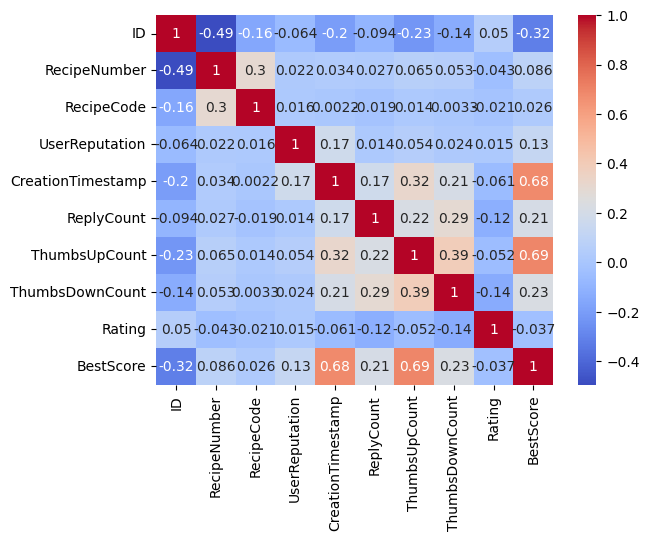

In [5]:
#Correlation Matrix
corr_matrix = trainset[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

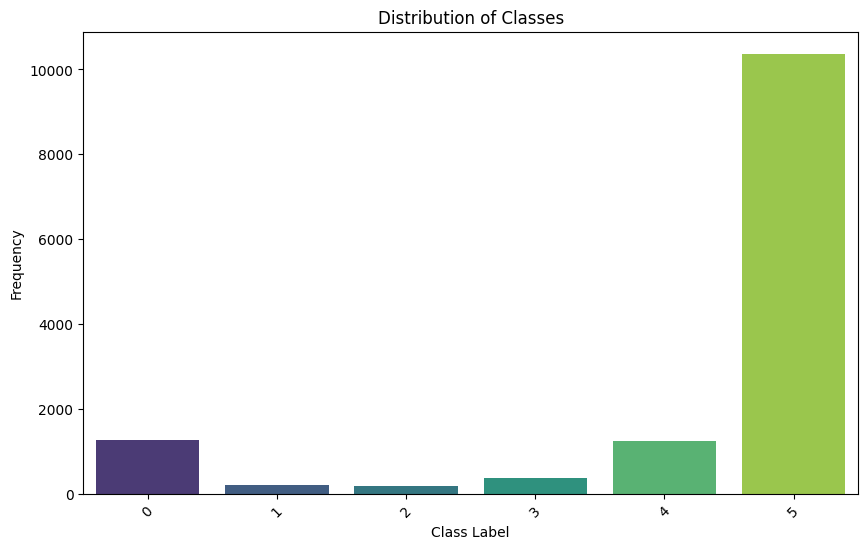

In [6]:
# Counting the occurrences of each class label
class_counts = trainset['Rating'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribution of Classes')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# The dataset is unbalanced and thus, needs to be balanced before the model building process.

In [7]:
#Cleaning the data by filling missing values.
for col in train_cols_with_null:
    trainset[col].fillna(" ",inplace=True)
for col in test_cols_with_null:
    testset[col].fillna(" ",inplace=True)

In [8]:
#Vectorizing the text.
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_text_tfidf = tfidf_vectorizer.fit_transform(trainset['Recipe_Review'])
X_test_text_tfidf = tfidf_vectorizer.transform(testset['Recipe_Review'])

In [9]:
# One-hot encoding the categorical features.
categorical_columns = ['RecipeNumber', 'RecipeCode']
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_cat_encoded = onehot_encoder.fit_transform(
    trainset[categorical_columns])
X_test_cat_encoded = onehot_encoder.transform(testset[categorical_columns])

In [10]:
#Dropping features.
columns_to_drop = ['RecipeName', 'CommentID', 'UserID',
                   'UserName','Recipe_Review', 'RecipeNumber', 'RecipeCode']
trainset = trainset.drop(columns=columns_to_drop)
testset = testset.drop(columns=columns_to_drop)

In [11]:
#Splitting into Features and target.
X_train = trainset.drop('Rating', axis=1)
y_train = trainset['Rating']
X_test = testset

In [12]:
#Concatenating the vectorized text with the dataset.
X_train_text_tfidf_df = pd.DataFrame(X_train_text_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
X_test_text_tfidf_df = pd.DataFrame(X_test_text_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tf_columns_to_drop = ["10", "12", "13", "15", "16", "18", "20", "25",
                      "2nd", "30", "34", "35", "350", "39", "40", "45", "50", "9x13", "14"]
X_train_text_tfidf_df.drop(columns=tf_columns_to_drop, inplace=True)
X_test_text_tfidf_df.drop(columns=tf_columns_to_drop, inplace=True)
X_train = pd.concat([X_train_text_tfidf_df, X_train.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test_text_tfidf_df, X_test.reset_index(drop=True)], axis=1)

In [13]:
# Combining the one-hot encoded features with the rest of the dataset.
X_train = pd.concat([pd.DataFrame(X_train_cat_encoded, columns=onehot_encoder.get_feature_names_out(
)), X_train.reset_index(drop=True)], axis=1)
X_test = pd.concat([pd.DataFrame(X_test_cat_encoded, columns=onehot_encoder.get_feature_names_out(
)), X_test.reset_index(drop=True)], axis=1)

In [14]:
#Oversampling the classes.
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

print(X_train.shape)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

(62226, 1188)


# **Dummy Classifier**

In [15]:
'''dummy_classifier = DummyClassifier(strategy='stratified') 
dummy_classifier.fit(X_train, y_train)

y_pred = dummy_classifier.predict(X_test)

submission_df = pd.DataFrame({'Rating': y_pred})
submission_df['ID'] = range(1, len(submission_df) + 1)
submission_df = submission_df[['ID', 'Rating']]                              

submission_file_path = '/kaggle/working/submission.csv'
submission_df.to_csv(submission_file_path, index=False)'''

"dummy_classifier = DummyClassifier(strategy='stratified') \ndummy_classifier.fit(X_train, y_train)\n\ny_pred = dummy_classifier.predict(X_test)\n\nsubmission_df = pd.DataFrame({'Rating': y_pred})\nsubmission_df['ID'] = range(1, len(submission_df) + 1)\nsubmission_df = submission_df[['ID', 'Rating']]                              \n\nsubmission_file_path = '/kaggle/working/submission.csv'\nsubmission_df.to_csv(submission_file_path, index=False)"

# **KNN Algorithm with hyperparameter tuning**

In [16]:
'''# Define the parameter values that should be searched
k_range = list(range(1, 31))

# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)

# Instantiate the grid
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=2, scoring='accuracy')

# Fit the grid with data
grid.fit(X_train, y_train)

# View the results
print("Best Parameters:", grid.best_params_)
print("Best Accuracy:", grid.best_score_)

#Best found parameter is 26.'''

'# Define the parameter values that should be searched\nk_range = list(range(1, 31))\n\n# Create a parameter grid: map the parameter names to the values that should be searched\nparam_grid = dict(n_neighbors=k_range)\n\n# Instantiate the grid\ngrid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=2, scoring=\'accuracy\')\n\n# Fit the grid with data\ngrid.fit(X_train, y_train)\n\n# View the results\nprint("Best Parameters:", grid.best_params_)\nprint("Best Accuracy:", grid.best_score_)\n\n#Best found parameter is 26.'

# **SVM Algorithm with hyperparameter tuning**

In [17]:
'''# Define the parameter values that should be searched
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]

# Instantiate the grid
grid = GridSearchCV(SVC(), param_grid, cv=2, scoring='accuracy')

# Fit the grid with data
grid.fit(X_train, y_train)

# View the complete results
print("Best Parameters:", grid.best_params_)
print("Best Accuracy:", grid.best_score_)'''

'# Define the parameter values that should be searched\nparam_grid = [\n  {\'C\': [1, 10, 100, 1000], \'kernel\': [\'linear\']},\n  {\'C\': [1, 10, 100, 1000], \'gamma\': [0.001, 0.0001], \'kernel\': [\'rbf\']},\n]\n\n# Instantiate the grid\ngrid = GridSearchCV(SVC(), param_grid, cv=2, scoring=\'accuracy\')\n\n# Fit the grid with data\ngrid.fit(X_train, y_train)\n\n# View the complete results\nprint("Best Parameters:", grid.best_params_)\nprint("Best Accuracy:", grid.best_score_)'

# **Random Forest Algorithm with hyperparameter tuning**

In [18]:
'''#Training the model.
rf_classifier = RandomForestClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': list(range(80,101))
}

# Perform grid search
grid_search = GridSearchCV(rf_classifier, param_grid, cv=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)'''

'''rf_classifier = RandomForestClassifier(n_estimators=89, random_state=42)

# cross validation score
scores = cross_val_score(rf_classifier, X_train, y_train, cv=2)
print("Accuracy for each fold: ", scores)
print("Mean accuracy: ", scores.mean())'''

'rf_classifier = RandomForestClassifier(n_estimators=89, random_state=42)\n\n# cross validation score\nscores = cross_val_score(rf_classifier, X_train, y_train, cv=2)\nprint("Accuracy for each fold: ", scores)\nprint("Mean accuracy: ", scores.mean())'

# **Multilayered Perceptron classifier**


In [19]:
'''clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=42)

scores = cross_val_score(clf, X_train, y_train, cv=2)
print("Accuracy for each fold: ", scores)
print("Mean accuracy: ", scores.mean())'''

'clf = MLPClassifier(solver=\'lbfgs\', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=42)\n\nscores = cross_val_score(clf, X_train, y_train, cv=2)\nprint("Accuracy for each fold: ", scores)\nprint("Mean accuracy: ", scores.mean())'

# **Accuracy and insights achieved by various ML Models**

* **Dummy Classifier:** The dummy classifier is just used to check if the preprocessing steps maintain the integrity of the data. 
* **KNN Algorithm:** The best found **n_neighbors** parameter is **26** for the dataset. The accuracy achieved by this model was **0.76**.
* **SVM Algorithm:** SVM, being a very computationally expensive algorithm takes a lot of time to train on the dataset. The accuracy achieved by this model with **5 fold cross validation** was **0.78**.
* **Multilayered Perceptron:** The perceptron algorithm provided the worst result out of all the above algorithms. The accuracy achieved with **2 fold cross validation** was **0.16**.

**The Random Forest Model** provides the best accuracy out of all the above models. The dataset demonstrates a complex relationship between the target and the features. Thus, a complex model like the **rf_classifier** tends to provide the best results. 

# **Prediction with the best found model**

In [20]:
rf_classifier = RandomForestClassifier(n_estimators=89, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

'''knn_classifier = KNeighborsClassifier(n_neighbors=26)
knn_classifier.fit(X_train,y_train)

y_pred = knn_classifier.predict(X_test)'''

'''clf = xgb.XGBClassifier(objective='multi:softmax', num_class=6)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)'''

#Putting the prediction into csv.
submission_df = pd.DataFrame({'Rating': y_pred})
submission_df['ID'] = range(1, len(submission_df) + 1)
submission_df = submission_df[['ID', 'Rating']]

#Creating the submission csv.
submission_file_path = '/kaggle/working/submission.csv'
submission_df.to_csv(submission_file_path, index=False)